In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import kde
from fitter import Fitter, get_common_distributions, get_distributions
# from matplotlib.mlab import bivariate_normal
from mpl_toolkits.mplot3d import Axes3D

In [2]:
data=pd.read_csv('user_files\\BBS0039.csv')
data.head(12)

,str_date,Negative,Neutral,Positive,Logoff,Logon,Connect,Disconnect
0,01-04-2010,4.0,1.0,6.0,3,3,0.0,0.0
1,01-05-2010,6.0,1.0,4.0,3,3,0.0,0.0
2,01-06-2010,4.0,1.0,5.0,3,3,0.0,0.0
3,01-07-2010,5.0,1.0,5.0,3,3,0.0,0.0
4,01-08-2010,6.0,0.0,4.0,4,4,0.0,0.0
5,01-11-2010,2.0,0.0,9.0,2,2,0.0,0.0
6,01-12-2010,5.0,0.0,6.0,5,5,0.0,0.0
7,01-13-2010,5.0,2.0,3.0,3,3,0.0,0.0
8,01-14-2010,4.0,0.0,7.0,6,6,0.0,0.0
9,01-15-2010,6.0,1.0,3.0,4,4,0.0,0.0


In [3]:
data['str_date']=pd.to_datetime(data['str_date'])
d=list(data['str_date'].to_numpy())
clean_dates=[]
for i in d:
    i=str(i).split('T')
    clean_dates.append(i[0])
clean_dates

['2010-01-04',
 '2010-01-05',
 '2010-01-06',
 '2010-01-07',
 '2010-01-08',
 '2010-01-11',
 '2010-01-12',
 '2010-01-13',
 '2010-01-14',
 '2010-01-15',
 '2010-01-18',
 '2010-01-19',
 '2010-01-20',
 '2010-01-21',
 '2010-01-22',
 '2010-01-25',
 '2010-01-26',
 '2010-01-27',
 '2010-01-28',
 '2010-01-29',
 '2010-02-01',
 '2010-02-02',
 '2010-02-03',
 '2010-02-04',
 '2010-02-05',
 '2010-02-08',
 '2010-02-09',
 '2010-02-10',
 '2010-02-11',
 '2010-02-12',
 '2010-02-15',
 '2010-02-16',
 '2010-02-17',
 '2010-02-18',
 '2010-02-19',
 '2010-02-22',
 '2010-02-23',
 '2010-02-24',
 '2010-02-25',
 '2010-02-26',
 '2010-03-01',
 '2010-03-02',
 '2010-03-03',
 '2010-03-04',
 '2010-03-05',
 '2010-03-08',
 '2010-03-09',
 '2010-03-10',
 '2010-03-11',
 '2010-03-12',
 '2010-03-15',
 '2010-03-16',
 '2010-03-17',
 '2010-03-18',
 '2010-03-19',
 '2010-03-22',
 '2010-03-23',
 '2010-03-24',
 '2010-03-25',
 '2010-03-26',
 '2010-03-29',
 '2010-03-30',
 '2010-03-31',
 '2010-04-01',
 '2010-04-05',
 '2010-04-06',
 '2010-04-

In [4]:
data.describe()
data['Logoff'].describe()

count    157.000000
mean       4.222930
std        1.398712
min        2.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        6.000000
Name: Logoff, dtype: float64

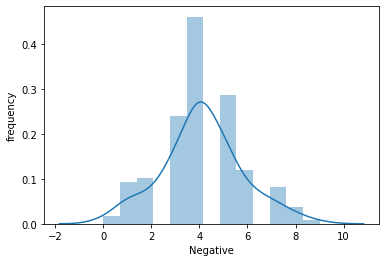

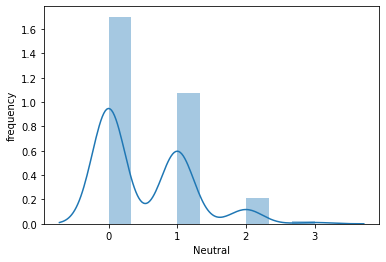

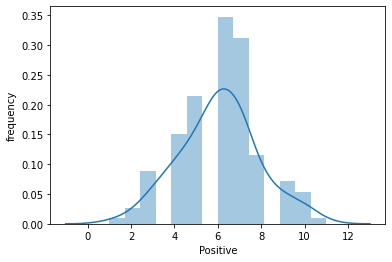

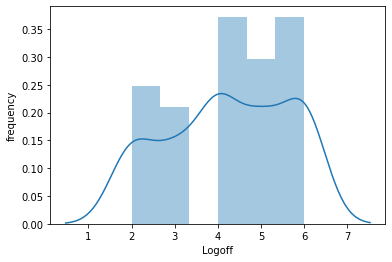

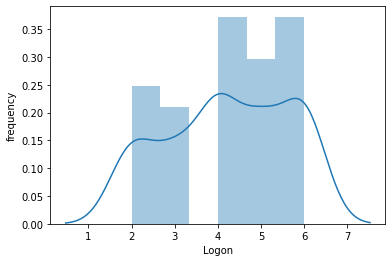

In [5]:
cols=list(data.columns)
cols.remove('str_date')

plt.xlabel(cols[0])
plt.ylabel('frequency')
sns.distplot(data[cols[0]])
plt.show()
plt.xlabel(cols[1])
plt.ylabel('frequency')
sns.distplot(data[cols[1]])
plt.show()
plt.xlabel(cols[2])
plt.ylabel('frequency')
sns.distplot(data[cols[2]])
plt.show()
plt.xlabel(cols[3])
plt.ylabel('frequency')
sns.distplot(data[cols[3]])
plt.show()
plt.xlabel(cols[4])
plt.ylabel('frequency')
sns.distplot(data[cols[4]])
plt.show()

### normalizing the data

In [6]:
scaler=MinMaxScaler()
names=data.columns
norm=pd.DataFrame(scaler.fit_transform(data.iloc[ :,1:]), columns=names[1: ])


In [7]:
standard=StandardScaler()
s=pd.DataFrame(standard.fit_transform(data.iloc[:,1:]), columns=names[1: ])
s['Logoff'].describe()

count    1.570000e+02
mean     2.036587e-16
std      1.003200e+00
min     -1.594355e+00
25%     -8.771239e-01
50%     -1.598924e-01
75%      5.573392e-01
max      1.274571e+00
Name: Logoff, dtype: float64

In [8]:
email_sentiments=data.iloc[:, [1,2, 3]]
# f = Fitter(email_sentiments['Negative'].values)
# f.fit()
# f.summary()

### This method estimates the probabilities- Using hypercube kernel 

In [9]:
def parzen_window_est(x_samples, h=1, center=[0,0,0]):
    
    '''
    Implementation of the Parzen-window estimation for hypercubes.

    Keyword arguments:
        x_samples: A 'n x d'-dimensional numpy array, where each sample
            is stored in a separate row.
        h: The length of the hypercube.
        center: The coordinate center of the hypercube

    Returns the probability density for observing k samples inside the hypercube.

    '''
    dimensions = x_samples.shape[1]

    assert (len(center) == dimensions),'Number of center coordinates have to match sample dimensions'
    k = 0
    for x in x_samples:
        is_inside = 1
        for axis,center_point in zip(x, center):
            if np.abs(axis-center_point) > (h/2):
                is_inside = 0
        k += is_inside
    return (k / len(x_samples)) / (h**dimensions)



email_sentiments=data.iloc[:, [1,2, 3]]
email_sentiments=email_sentiments.to_numpy()
print('p(x) =', parzen_window_est(email_sentiments, h=1))
email_sentiments.shape

p(x) = 0.0


(157, 3)

### plotting the dataset to identify the underlying distribution of dataset

In [10]:
# dates_array=data['str_date'].to_numpy()
# f, ax = plt.subplots(figsize=(7, 7))
# ax.scatter(email_sentiments[:,0], email_sentiments[:,1],
#         marker='o', color='green', s=4, alpha=0.5)
# plt.title('plotting samples randomly from an unknown 2D distribution')
# plt.ylabel('x2')
# plt.xlabel('x1')
# ftext = 'p(x) ~ N(mu=(0,0)^t, cov=I)'
# plt.figtext(.15,.85, ftext, fontsize=11, ha='left')
# plt.ylim([-4,4])
# plt.xlim([-4,4])

# plt.show()

#not useful for now

In [11]:
# not be used because we have more than 3 variables
def bivariate_normal(X, Y, sigmax=1.0, sigmay=1.0,
                 mux=0.0, muy=0.0, sigmaxy=0.0):
    """
    Bivariate Gaussian distribution for equal shape *X*, *Y*.
    See `bivariate normal
    <http://mathworld.wolfram.com/BivariateNormalDistribution.html>`_
    at mathworld.
    """
    Xmu = X-mux
    Ymu = Y-muy

    rho = sigmaxy/(sigmax*sigmay)
    z = Xmu**2/sigmax**2 + Ymu**2/sigmay**2 - 2*rho*Xmu*Ymu/(sigmax*sigmay)
    denom = 2*np.pi*sigmax*sigmay*np.sqrt(1-rho**2)
    return np.exp(-z/(2*(1-rho**2))) / denom

### this method calculates the actual densities

In [12]:
def pdf_multivariate_gauss(x, mu, cov):
    '''
    Caculate the multivariate normal density (pdf)

    Keyword arguments:
        x = numpy array of a "d x 1" sample vector
        mu = numpy array of a "d x 1" mean vector
        cov = "numpy array of a d x d" covariance matrix
        this method implements the actual gaussian distribution formula
    '''
    assert(mu.shape[0] > mu.shape[1]),\
        'mu must be a row vector'
    assert(x.shape[0] > x.shape[1]),\
        'x must be a row vector'
    assert(cov.shape[0] == cov.shape[1]),\
        'covariance matrix must be square'
    assert(mu.shape[0] == cov.shape[0]),\
        'cov_mat and mu_vec must have the same dimensions'
    assert(mu.shape[0] == x.shape[0]),\
        'mu and x must have the same dimensions'

    part1 = 1 / ( ((2* np.pi)**(len(mu)/2)) * (np.linalg.det(cov)**(1/2)) )
    part2 = (-1/2) * ((x-mu).T.dot(np.linalg.inv(cov))).dot((x-mu))
    return float(part1 * np.exp(part2))

In [13]:

x = np.array([[0],[0],[0]])how
mu = np.array([[0],[0],[0]])
# print(mu.shape[0], email_sentiments.shape[0], email_sentiments.shape[1])
cov = np.eye(3)

mlab_gauss = bivariate_normal(x,x)
mlab_gauss = float(mlab_gauss[0]) # because mlab returns an np.array
impl_gauss = pdf_multivariate_gauss(x, mu, cov)

print('mlab_gauss:', mlab_gauss)
print('impl_gauss:', impl_gauss)
assert(mlab_gauss == impl_gauss),\
        'Implementations of the mult. Gaussian return different pdfs'


SyntaxError: invalid syntax. Perhaps you forgot a comma? (208125192.py, line 1)

### Comparing the Parzen-window estimation to the actual densities

In [14]:
##x_2Dguass is a randomly generated array of n samples, that follow a guassian distribution, but here I'll apply the actual data points 
print(email_sentiments.shape)
print('Predict p(x) at the center [0,0]: ')

print('h = 0.1 ---> p(x) =', parzen_window_est(email_sentiments, h=0.1, center=[0, 0,0])
        )
print('h = 0.3 ---> p(x) =',parzen_window_est(email_sentiments, h=0.3, center=[0,0, 0])
        )
print('h = 0.6 ---> p(x) =',parzen_window_est(email_sentiments, h=0.6, center=[0,0, 0])
        )
print('h = 0.85 ---> p(x) =',parzen_window_est(email_sentiments, h=0.85, center=[0,0, 0]))


(157, 3)
Predict p(x) at the center [0,0]: 
h = 0.1 ---> p(x) = 0.0
h = 0.3 ---> p(x) = 0.0
h = 0.6 ---> p(x) = 0.0
h = 0.85 ---> p(x) = 0.0


In [15]:
# mu_vec = np.array([0,0])
# cov_mat = np.array([[1,0],[0,1]])
# x_2Dgauss = np.random.multivariate_normal(mu_vec, cov_mat, 10000)
email_sentiments[0]

array([4., 1., 6.])

In [16]:
import prettytable

p1 = parzen_window_est(email_sentiments, h=0.85, center=[0, 0,0])
p2 = parzen_window_est(email_sentiments, h=21, center=[1, 2, 2])
p3 = parzen_window_est(email_sentiments, h=2, center=[0, 2, 1])

mu = np.array([[0],[0], [0]])
cov = np.eye(3)

a1 = pdf_multivariate_gauss(email_sentiments, mu, cov)
a2 = pdf_multivariate_gauss(np.array([[1],[2], [2]]), mu, cov)
a3 = pdf_multivariate_gauss(np.array([[0],[2],[1]]), mu, cov)

results = prettytable.PrettyTable(["", "predicted", "actual"])
results.add_row(["p([0, 0, 0]^t",p1, a1])
results.add_row(["p([0.5, 0.5, 0.5]^t",p2, a2])
results.add_row(["p([0.3, 0.2, 0.4]^t",p3, a3])

print(results)

AssertionError: mu and x must have the same dimensions

### using builtin gaussian kernel from scipy library

In [20]:
from scipy.stats import kde
print((email_sentiments.T).shape)
density = kde.gaussian_kde(email_sentiments.T, bw_method=2.31)
print(density.evaluate(np.array([[9],[8],[7]])))
# email_sentiments

(3, 157)
[2.56946954e-14]
